In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
workdir_path = '/content/drive/My Drive/Fugitivas' #OK!
os.chdir(workdir_path)

Mounted at /content/drive


O dataset de imagens foi gerado a partir de videos de detecção de vazamentos em componentes de linhas de processo ( flanges e caps). Foram realizados recortes de figuras nos videos que forma salvas em .jpg

In [ ]:
import sys
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import glob
from imutils import paths

In [ ]:
INIT_LR = 1e-3
EPOCHS = 15 # FIZ TESTES com 5, 10 e 20
BS = 8

In [ ]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images 
dataset_path = 'Dataset2'
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []

[INFO] loading images...


In [ ]:
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
print("labels: ", np.unique(labels))

labels:  ['COMfugitivas' 'SEMfugitivas']


In [ ]:
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]
data = np.array(data) / 255.0
labels = np.array(labels)

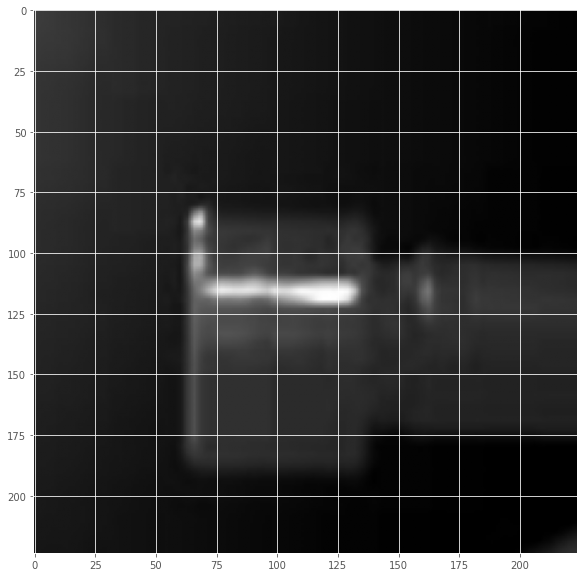

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(data[labels=='SEMfugitivas'][5])
plt.show()

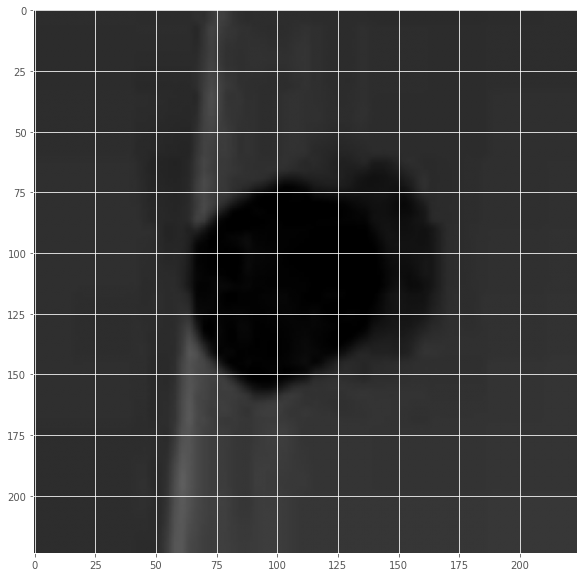

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(data[labels=='COMfugitivas'][5])
plt.show()

In [ ]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [ ]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                  test_size=0.20, stratify=labels, random_state=42)

In [ ]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=30,
    fill_mode="nearest")

In [ ]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
                  input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
              metrics=["accuracy"])

[INFO] compiling model...


In [ ]:
baseModel = VGG16(weights="imagenet", include_top=False,
                  input_tensor=Input(shape=(224, 224, 3)))

f1 = baseModel.layers[1].output
f2 = baseModel.layers[2].output
f3 = baseModel.layers[4].output
f4 = baseModel.layers[5].output
feature_maps = Model(inputs=baseModel.input, outputs=[f1, f2, f3, f4])

In [ ]:
y = np.argmax(trainY, axis=-1)

In [ ]:
feat1, feat2, feat3, feat4 = feature_maps.predict(trainX[y==1][0:1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


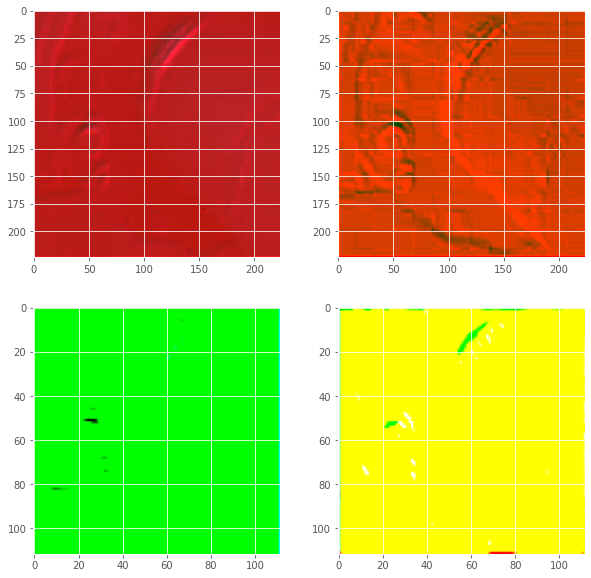

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(feat1[0, :, :, 0:3])
axs[0, 1].imshow(feat2[0, :, :, 6:9])
axs[1, 0].imshow(feat3[0, :, :, 0:3])
axs[1, 1].imshow(feat4[0, :, :, 3:6])
# plt.subplots
# plt.imshow(feat1[0, :, :, 0:3])
plt.show()

In [ ]:
# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] training head...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
1/1 [==============================] - 2s 2s/step - loss: 0.7448 - accuracy: 0.5000
Epoch 2/15
1/1 [==============================] - 4s 4s/step - loss: 0.8248 - accuracy: 0.5000
Epoch 3/15
1/1 [==============================] - 1s 1s/step - loss: 1.1317 - accuracy: 0.0000e+00
Epoch 4/15
1/1 [==============================] - 1s 1s/step - loss: 0.7519 - accuracy: 0.5000
Epoch 5/15
1/1 [==============================] - 4s 4s/step - loss: 0.8803 - accuracy: 0.3750
Epoch 6/15
1/1 [==============================] - 1s 1s/step - loss: 0.6237 - accuracy: 1.0000
Epoch 7/15
1/1 [==============================] - 1s 1s/step - loss: 1.0416 - accuracy: 0.0000e+00
Epoch 8/15
1/1 [==============================] - 1s 1s/step - loss: 0.5615 - accuracy: 0.5000
Epoch 9/15
1/1 [==============================] - 1s 1s/step - loss: 0.6557 - accuracy: 0.5000
Epoch 10/15
1/1 [==============================] - 4s 4s/step - loss: 0.7230 - accuracy: 0.6250
Epoch 11/15
1/1 [========================

[INFO] evaluating network...
              precision    recall  f1-score   support

COMfugitivas       0.67      1.00      0.80         2
SEMfugitivas       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3

[[2 0]
 [1 0]]
acc: 0.6667
sensitivity: 1.0000
specificity: 0.0000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KeyError: ignored

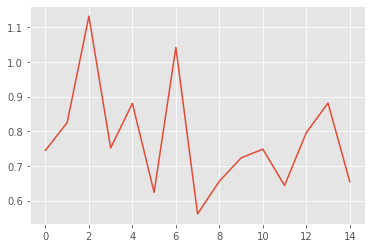

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
                            target_names=lb.classes_))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Fugitivas Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
# plt.savefig(args["plot"])

# serialize the model to disk
# print("[INFO] saving Fugitivas detector model...")
# model.save(args["model"], save_format="h5")